In [ ]:
!pip install tensorflow==2.7.0

In [ ]:
!pip install tensorflow-text==2.7.3

In [3]:
!pip install pyenchant

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 55 kB 2.6 MB/s 


In [4]:
!pip install nltk

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
!pip install jiwer
!pip install sacrebleu
!pip install rouge_score

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.4 MB 6.9 MB/s 
     |████████████████████████████████| 1.6 MB 38.6 MB/s 
     |████████████████████████████████| 104 kB 48.6 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 116 kB 8.3 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24955 sha256=112755706a95278ba20d65a5eb739ea6589a8d06246160b95293e4db2df1e4c1
  Stored in directory: /root/.cache/pip/wheels/84/ac/6b/38096e3c5bf1dc87911e3585875e21a3ac610348e740409c76
Successfully built rouge-score


In [6]:
from rouge_score import rouge_scorer
import nltk.translate.bleu_score as bleu
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [7]:
import numpy as np
import typing
from typing import Any, Tuple
from nltk.tokenize import RegexpTokenizer
import tensorflow as tf
import re
import tensorflow_text as tf_text
import pandas as pd
import io
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from jiwer import wer
from sacrebleu import sentence_bleu
from nltk.translate.meteor_score import meteor_score

In [9]:
from google.colab import files
uploaded = files.upload()

Saving English-Hindi code-mixed parallel corpus.csv to English-Hindi code-mixed parallel corpus.csv


In [10]:
# Importing the 'train_test_split' library from the 'sklearn' library.
# This is used for splitting the dataset into test and train datasets.

from sklearn.model_selection import train_test_split

phinc_df=pd.read_csv(io.BytesIO(uploaded['English-Hindi code-mixed parallel corpus.csv']))

# Split of data -> 70% training data means 0.7*number of rows in new dataset.

# Setting the randomness to 100 to reproduce results. 

xTrain, xTest, yTrain, yTest = train_test_split(phinc_df['Sentence']
                                                ,phinc_df['English_Translation']
                                                ,test_size = 0.3,random_state = 100
                                                ,shuffle = True)

# Combining training and testing data into single data frames.

phinc_train_df=pd.concat([xTrain,yTrain],axis = 1)
phinc_test_df=pd.concat([xTest,yTest],axis = 1)

In [11]:
# Creating a function that pre-processes the text data. 

# Pre-processing includes changing the text to lowercase, removing links,
# stemming, lemmatization, etc.

def text_preprocessing(text):
    text = text.lower()
    pat= re.compile('<.*?>')
    text= re.sub(pat, '', text)
    text= re.sub('[0-9]+', '', text)
    text=re.sub(r'http\S+', '',text)
    tokenizer = RegexpTokenizer(r'\w+')
    text = tokenizer.tokenize(text)
    return " ".join(text)

# Performing text pre-processing on training and testing data.

phinc_train_preprocessed_data=pd.DataFrame()
phinc_test_preprocessed_data=pd.DataFrame()
phinc_train_preprocessed_data['Sentence']=phinc_train_df['Sentence'].apply(text_preprocessing)
phinc_train_preprocessed_data['English_Translation']=phinc_train_df['English_Translation'].apply(text_preprocessing)
phinc_test_preprocessed_data['Sentence']=phinc_test_df['Sentence'].apply(text_preprocessing)
phinc_test_preprocessed_data['English_Translation']=phinc_test_df['English_Translation'].apply(text_preprocessing)


In [12]:
hinglish=phinc_train_preprocessed_data['Sentence'].to_list()
english=phinc_train_preprocessed_data['English_Translation'].to_list()

In [13]:
# Buffer size for shuffling datasets
BUFFER_SIZE = len(hinglish)  

# Batch Size for training 
BATCH_SIZE = 64  

dataset = tf.data.Dataset.from_tensor_slices((hinglish, english)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)

In [14]:
for example_hinglish_batch, example_english_batch in dataset.take(1):
    print(example_hinglish_batch[:5])
    print()
    print(example_english_batch[:5])
    break

tf.Tensor(
[b'vijaykr haww tasneembulsara dekho ye kya bol raha hai'
 b'lakh logo ko subah se block kar chuki hai masalabaipic twitter com bgeoggjh'
 b'javedakhtarjadu bhai tu bada jolllyllb ban ke ghum riya hai jab jnu me anti national slogans gunj rahe the tab kaha the mr literate'
 b'bhuk lagi ho khana samne pada ho aur dieting ke naan pe mana karna pada tab jo dard hota hai woh en congressiyo se pucho'
 b'for the french fan of someuser the tvmovie drew peterson untouchable will be broadcasted thusday october at pm on tf'], shape=(5,), dtype=string)

tf.Tensor(
[b'vijaykr haww tasneembulsara look what he is speaking'
 b'she has blocked lakh people since morning masalabaipic twitter com bgeoggjh'
 b'javedakhtarjadu you are roaming around being jolllyllb where were you when anti national slogans were sung in jnu mr literate'
 b'when you are hungry and food is in front of you but still you refuse because of dieting ask congressiyo about that pain'
 b'for the french fan of someuser the 

In [15]:
# Creating a function that removes punctuations from the pre-processed text data
# and normalized.

def tf_lower_and_split_punct(text):
    text = tf_text.normalize_utf8(text, 'NFKD')
    text = tf.strings.lower(text)
    text = tf.strings.regex_replace(text, '[.?!,¿]', r' \0 ')
    text = tf.strings.regex_replace(text, '[^ a-z.?!,¿]', '')

    text = tf.strings.strip(text)

    text = tf.strings.join(['[START]', text, '[END]'], separator=' ')
    return text

In [16]:
example_text = tf.constant('aaj zoom meeting kitne baje schedule karni hai?')
print(example_text.numpy().decode())
print(tf_lower_and_split_punct(example_text).numpy().decode())

aaj zoom meeting kitne baje schedule karni hai?
[START] aaj zoom meeting kitne baje schedule karni hai ? [END]


In [17]:
max_vocab_size = 7000

# handles vocabulary extraction & conversion of input/processing text to sequences of tokens
input_text_processor = tf.keras.layers.TextVectorization(standardize=tf_lower_and_split_punct,max_tokens=max_vocab_size)
output_text_processor = tf.keras.layers.TextVectorization(standardize=tf_lower_and_split_punct, max_tokens=max_vocab_size)


In [18]:
 # Initializing the layer based on the data
input_text_processor.adapt(hinglish)
output_text_processor.adapt(english)
print(input_text_processor.get_vocabulary()[:10])
print(output_text_processor.get_vocabulary()[:10])


['', '[UNK]', '[START]', '[END]', 'hai', 'to', 'nahi', 'ke', 'ki', 'bhi']
['', '[UNK]', '[START]', '[END]', 'the', 'you', 'is', 'to', 'i', 'a']


In [19]:
# Embedding dimensions for input text
embedding_dim = 256 

# No of parallel units for GRU
units = 512 

The attention weight $\alpha_{ij}$, the $i$th decoder step over the $j$th encoder step, resulting in context vector $c_i$



1. Equation 1



$c_i = \sum_{j=1}^{T_x} \alpha_{ij}h_j$

---


2. Equation 2


$\alpha_{ij} = \frac{\exp(e_{ij})}{\sum_{k=1}^{T_x} \exp(e_{ik})}$

---


3. Equation 3



$e_{ij} = a(s_{i-1}, h_j)$

---


a is a Bahdanau attention function, given as below


4. Equation 4

$e_{ij} = v^T tanh(W[s_{i-1}; h_j])$

---

Finally, the output $o_i$ is produced by:

5. Equation 5

$s_t = tanh(W[s_{t-1};y_t;c_t])$

---

6. Equation 6


$o_t = softmax(Vs_t)$

---




In [20]:
# Defining the Encoder class

class Encoder(tf.keras.layers.Layer):
    def __init__(self, input_vocab_size, embedding_dim, enc_units):
        super(Encoder, self).__init__()
        self.enc_units = enc_units
        self.input_vocab_size = input_vocab_size

        # The embedding layer converts tokens to vectors
        self.embedding = tf.keras.layers.Embedding(self.input_vocab_size,
                                                   embedding_dim)

       # The GRU RNN layer processes those vectors sequentially.
       # Return the sequence and state if parameter 'return_sequences' is set as True
        self.gru = tf.keras.layers.GRU(self.enc_units,
                                       return_sequences=True,  
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')

    def call(self, tokens, state=None):
        # The embedding layer looks up the embedding for each token.
        vectors = self.embedding(tokens)
        
        # The GRU processes the embedding sequence
        # Output shape: (batch, s, enc_units) , state shape: (batch, enc_units)
        output, state = self.gru(vectors, initial_state=state) 
        
        # Returns the new sequence and its state
        return output, state

In [21]:
# Implementation of Bahdanau Attention as shown above in Equation 4

class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super().__init__()
        self.W1 = tf.keras.layers.Dense(units, use_bias=False)
        self.W2 = tf.keras.layers.Dense(units, use_bias=False)

        self.attention = tf.keras.layers.AdditiveAttention()

    def call(self, query, value, mask):
        w1_query = self.W1(query)
        w2_key = self.W2(value)
        

        query_mask = tf.ones(tf.shape(query)[:-1], dtype=bool)
        value_mask = mask

        context_vector, attention_weights = self.attention(
            inputs = [w1_query, value, w2_key],
            mask=[query_mask, value_mask],
            return_attention_scores = True,
        )
       
        return context_vector, attention_weights

In [22]:
# Defining the Decoder class

class Decoder(tf.keras.layers.Layer):
    def __init__(self, output_vocab_size, embedding_dim, dec_units):
        super(Decoder, self).__init__()
        self.dec_units = dec_units
        self.output_vocab_size = output_vocab_size
        self.embedding_dim = embedding_dim

        #The embedding layer converts token IDs to vectors
        self.embedding = tf.keras.layers.Embedding(self.output_vocab_size,
                                                   embedding_dim)

        #The RNN keeps track of what's been generated so far
        self.gru = tf.keras.layers.GRU(self.dec_units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')

        #The RNN output will be the query for the attention layer.
        self.attention = BahdanauAttention(self.dec_units)

        
        self.Wc = tf.keras.layers.Dense(dec_units, activation=tf.math.tanh,
                                        use_bias=False)

         #fully connected layer produces the logits for each output token.
        self.fc = tf.keras.layers.Dense(self.output_vocab_size)

In [23]:
class DecoderInput(typing.NamedTuple):
    new_tokens: Any
    enc_output: Any
    mask: Any

class DecoderOutput(typing.NamedTuple):
    logits: Any
    attention_weights: Any

In [24]:
def call(self,
         inputs: DecoderInput,
         state=None) -> Tuple[DecoderOutput, tf.Tensor]:
    # Lookup the embeddings
    vectors = self.embedding(inputs.new_tokens)
    # Process one step with the RNN
    rnn_output, state = self.gru(vectors, initial_state=state)   
    # Use the RNN output as the query for the attention over the encoder output. 
    context_vector, attention_weights = self.attention(query=rnn_output, value=inputs.enc_output, mask=inputs.mask)
    # Join the context_vector and rnn_output
    # [ct; ht] shape: (batch t, value_units + query_units)
    context_and_rnn_output = tf.concat([context_vector, rnn_output], axis=-1)
    attention_vector = self.Wc(context_and_rnn_output)
    # Generate logit predictions
    logits = self.fc(attention_vector)
    return DecoderOutput(logits, attention_weights), state

In [25]:
Decoder.call = call
decoder = Decoder(output_text_processor.vocabulary_size(),embedding_dim, units)
vocab = np.array(output_text_processor.get_vocabulary())

In [30]:
# Defining the Loss function class
class MaskedLoss(tf.keras.losses.Loss):
    def __init__(self):
        self.name = 'masked_loss'
        self.loss = tf.keras.losses.SparseCategoricalCrossentropy(
            from_logits=True, reduction='none')

    def __call__(self, y_true, y_pred):   
        # Calculate the loss for each item in the batch  
        loss = self.loss(y_true, y_pred)

        # Mask off the losses on padding
        mask = tf.cast(y_true != 0, tf.float32)
        loss *= mask

        # Return the total
        return tf.reduce_sum(loss)

In [32]:
# Defining the Training Translator class
class TrainTranslator(tf.keras.Model):
    def __init__(self, embedding_dim, units,
               input_text_processor,
               output_text_processor, 
               use_tf_function=True):
        super().__init__()
        # Build the encoder and decoder
        encoder = Encoder(input_text_processor.vocabulary_size(),
                          embedding_dim, units)
        decoder = Decoder(output_text_processor.vocabulary_size(),
                          embedding_dim, units)

        self.encoder = encoder
        self.decoder = decoder
        self.input_text_processor = input_text_processor
        self.output_text_processor = output_text_processor
        self.use_tf_function = use_tf_function

    def train_step(self, inputs):
        if self.use_tf_function:
            return self._tf_train_step(inputs)
        return self._train_step(inputs)

In [33]:
# Receiving batches of English & Hinglish data
# Converting those raw text inputs to token-embeddings and masks.
def _preprocess(self, input_text, target_text):
    
    input_tokens = self.input_text_processor(input_text)
    target_tokens = self.output_text_processor(target_text)
    
    input_mask = input_tokens != 0
    
    target_mask = target_tokens != 0
    return input_tokens, input_mask, target_tokens, target_mask

In [34]:
TrainTranslator._preprocess = _preprocess

In [35]:
# Training steps
def _train_step(self, inputs):
    input_text, target_text = inputs  

    (input_tokens, input_mask,
    target_tokens, target_mask) = self._preprocess(input_text, target_text)

    max_target_length = tf.shape(target_tokens)[1]

    with tf.GradientTape() as tape:
        # Encode the input
        enc_output, enc_state = self.encoder(input_tokens)
        # Initialize the decoder's state to the encoder's final state.
    # This only works if the encoder and decoder have the same number of units.
        dec_state = enc_state
        loss = tf.constant(0.0)

        for t in tf.range(max_target_length-1):
            # Pass in two tokens from the target sequence:
            # 1. The current input to the decoder.
            # 2. The target for the decoder's next prediction.
            new_tokens = target_tokens[:, t:t+2]
            step_loss, dec_state = self._loop_step(new_tokens, input_mask,
                                                 enc_output, dec_state)
            loss = loss + step_loss

        # Average the loss over all non padding tokens.
        average_loss = loss / tf.reduce_sum(tf.cast(target_mask, tf.float32))

 
    variables = self.trainable_variables 
    gradients = tape.gradient(average_loss, variables)
    self.optimizer.apply_gradients(zip(gradients, variables))

    # Return a dict mapping metric names to current value
    return {'batch_loss': average_loss}

In [36]:
TrainTranslator._train_step = _train_step

In [37]:
# Executing the decoder and calculating the incremental loss and new decoder state 
def _loop_step(self, new_tokens, input_mask, enc_output, dec_state):
    input_token, target_token = new_tokens[:, 0:1], new_tokens[:, 1:2]

    # Run the decoder one step.
    decoder_input = DecoderInput(new_tokens=input_token,
                               enc_output=enc_output,
                               mask=input_mask)

    dec_result, dec_state = self.decoder(decoder_input, state=dec_state)
    
    # `self.loss` returns the total for non-padded tokens
    y = target_token
    y_pred = dec_result.logits
    step_loss = self.loss(y, y_pred)

    return step_loss, dec_state

In [38]:
TrainTranslator._loop_step = _loop_step

In [39]:
translator = TrainTranslator(
    embedding_dim, units,
    input_text_processor=input_text_processor,
    output_text_processor=output_text_processor,
    use_tf_function=False)

# Configure the loss and optimizer
translator.compile(
    optimizer=tf.optimizers.Adam(),
    loss=MaskedLoss(),
)

In [40]:
@tf.function(input_signature=[[tf.TensorSpec(dtype=tf.string, shape=[None]),
                               tf.TensorSpec(dtype=tf.string, shape=[None])]])
def _tf_train_step(self, inputs):
    return self._train_step(inputs)

In [41]:
TrainTranslator._tf_train_step = _tf_train_step

In [42]:
translator.use_tf_function = True

In [43]:
train_translator = TrainTranslator(
    embedding_dim, units,
    input_text_processor=input_text_processor,
    output_text_processor=output_text_processor)

# Configure the loss and optimizer
train_translator.compile(
    optimizer=tf.optimizers.Adam(),
    loss=MaskedLoss(),
)

In [44]:
# Defining the Batch Logs class which captures the logs.
class BatchLogs(tf.keras.callbacks.Callback):
    def __init__(self, key):
        self.key = key
        self.logs = []

    def on_train_batch_end(self, n, logs):
        self.logs.append(logs[self.key])

batch_loss = BatchLogs('batch_loss')

In [46]:
# Run the translator training model for 20 epoxhs.
train_translator.fit(dataset, epochs=20,callbacks=[batch_loss])

151/151 [==============================] - 68s 453ms/step - batch_loss: 4.5184
Epoch 10/20
151/151 [==============================] - 63s 419ms/step - batch_loss: 4.3307
Epoch 11/20
151/151 [==============================] - 64s 424ms/step - batch_loss: 4.1402
Epoch 12/20
151/151 [==============================] - 64s 421ms/step - batch_loss: 3.9332
Epoch 13/20
151/151 [==============================] - 64s 427ms/step - batch_loss: 3.7257
Epoch 14/20
151/151 [==============================] - 65s 428ms/step - batch_loss: 3.4946
Epoch 15/20
151/151 [==============================] - 66s 435ms/step - batch_loss: 3.2552
Epoch 16/20
151/151 [==============================] - 65s 432ms/step - batch_loss: 3.0048
Epoch 17/20
151/151 [==============================] - 64s 426ms/step - batch_loss: 2.7498
Epoch 18/20
151/151 [==============================] - 65s 430ms/step - batch_loss: 2.4985
Epoch 19/20
151/151 [==============================] - 65s 434ms/step - batch_loss: 2.2412
Epoch 20/20

Epoch 1/20
151/151 [==============================] - 64s 422ms/step - batch_loss: 1.7594
Epoch 2/20
151/151 [==============================] - 64s 425ms/step - batch_loss: 1.5432
Epoch 3/20
151/151 [==============================] - 63s 418ms/step - batch_loss: 1.3392
Epoch 4/20
151/151 [==============================] - 63s 420ms/step - batch_loss: 1.1474
Epoch 5/20
151/151 [==============================] - 63s 419ms/step - batch_loss: 0.9799
Epoch 6/20
151/151 [==============================] - 64s 424ms/step - batch_loss: 0.8294
Epoch 7/20
151/151 [==============================] - 63s 420ms/step - batch_loss: 0.6973
Epoch 8/20
151/151 [==============================] - 64s 426ms/step - batch_loss: 0.5685
Epoch 9/20
151/151 [==============================] - 63s 416ms/step - batch_loss: 0.4612
Epoch 10/20
151/151 [==============================] - 63s 419ms/step - batch_loss: 0.3691
Epoch 11/20
151/151 [==============================] - 63s 417ms/step - batch_loss: 0.2930
Epoch 12

Text(0.5, 0, 'Batch Number')

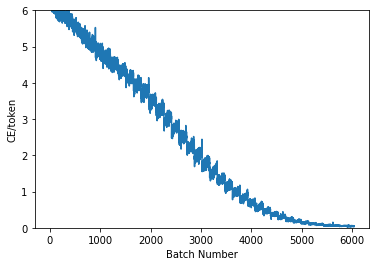

In [50]:
plt.plot(batch_loss.logs)
plt.ylim([0, 6])
plt.ylabel('CE/token')
plt.xlabel('Batch Number')

In [51]:
# Defining a translator class consisting of Encoder, Decoder, Input and Output
# Text processors.

class Translator(tf.Module):

  def __init__(self, encoder, decoder, input_text_processor,
               output_text_processor):
    self.encoder = encoder
    self.decoder = decoder
    self.input_text_processor = input_text_processor
    self.output_text_processor = output_text_processor

    self.output_token_string_from_index = (
        tf.keras.layers.StringLookup(
            vocabulary=output_text_processor.get_vocabulary(),
            mask_token='',
            invert=True))

    
    index_from_string = tf.keras.layers.StringLookup(
        vocabulary=output_text_processor.get_vocabulary(), mask_token='')
    token_mask_ids = index_from_string(['', '[UNK]', '[START]']).numpy()

    token_mask = np.zeros([index_from_string.vocabulary_size()], dtype=np.bool)
    token_mask[np.array(token_mask_ids)] = True
    self.token_mask = token_mask

    self.start_token = index_from_string(tf.constant('[START]'))
    self.end_token = index_from_string(tf.constant('[END]'))

In [52]:
translator = Translator(
    encoder=train_translator.encoder,
    decoder=train_translator.decoder,
    input_text_processor=input_text_processor,
    output_text_processor=output_text_processor,
)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [53]:
# Converting token IDs to human readable text
def tokens_to_text(self, result_tokens):
  result_text_tokens = self.output_token_string_from_index(result_tokens)
  
  result_text = tf.strings.reduce_join(result_text_tokens,
                                       axis=1, separator=' ')
  

  result_text = tf.strings.strip(result_text)
  
  return result_text

In [54]:
Translator.tokens_to_text = tokens_to_text

In [55]:
# The following function takes the decoder's logit outputs and samples token IDs from that distribution
def sample(self, logits, temperature):
  token_mask = self.token_mask[tf.newaxis, tf.newaxis, :]
  
  # Set the logits for all masked tokens to -inf, so they are never chosen.
  logits = tf.where(self.token_mask, -np.inf, logits)

  logits = tf.squeeze(logits, axis=1)
  new_tokens = tf.random.categorical(logits/temperature,num_samples=1)
  
  if temperature == 0.0:
    new_tokens = tf.argmax(logits, axis=-1)
  
  return new_tokens

In [56]:
Translator.sample = sample

In [57]:
# Implementing text to text translation loop
def translate_unrolled(self,
                       input_text, *,
                       max_length=50,
                       return_attention=True,
                       temperature=1.0):
  batch_size = tf.shape(input_text)[0]
  input_tokens = self.input_text_processor(input_text)
  enc_output, enc_state = self.encoder(input_tokens)

  dec_state = enc_state
  new_tokens = tf.fill([batch_size, 1], self.start_token)

  result_tokens = []
  attention = []
  done = tf.zeros([batch_size, 1], dtype=tf.bool)

  for _ in range(max_length):
    dec_input = DecoderInput(new_tokens=new_tokens,
                             enc_output=enc_output,
                             mask=(input_tokens!=0))
    
    dec_result, dec_state = self.decoder(dec_input, state=dec_state)

    attention.append(dec_result.attention_weights)

    new_tokens = self.sample(dec_result.logits, temperature)

    # If a sequence produces an `end_token`, set it `done
    done = done | (new_tokens == self.end_token)
    # Once a sequence is done it only produces 0-padding.
    new_tokens = tf.where(done, tf.constant(0, dtype=tf.int64), new_tokens)

    # Collect the generated tokens
    result_tokens.append(new_tokens)

    if tf.executing_eagerly() and tf.reduce_all(done):
      break

  # Convert the list of generates token ids to a list of strings.
  result_tokens = tf.concat(result_tokens, axis=-1)
  result_text = self.tokens_to_text(result_tokens)

  if return_attention:
    attention_stack = tf.concat(attention, axis=1)
    return {'text': result_text, 'attention': attention_stack}
  
  return {'text': result_text}


In [58]:
Translator.translate = translate_unrolled

In [59]:
@tf.function(input_signature=[tf.TensorSpec(dtype=tf.string, shape=[None])])
def tf_translate(self, input_text):
  return self.translate(input_text)

Translator.tf_translate = tf_translate

In [62]:
def translate_symbolic(self,
                       input_text,
                       *,
                       max_length=50,
                       return_attention=True,
                       temperature=1.0):
  
  batch_size = tf.shape(input_text)[0]

  
  input_tokens = self.input_text_processor(input_text)
  

  enc_output, enc_state = self.encoder(input_tokens)
  

  
  dec_state = enc_state
  new_tokens = tf.fill([batch_size, 1], self.start_token)
  

  
  result_tokens = tf.TensorArray(tf.int64, size=1, dynamic_size=True)
  attention = tf.TensorArray(tf.float32, size=1, dynamic_size=True)
  done = tf.zeros([batch_size, 1], dtype=tf.bool)
  
  for t in tf.range(max_length):
    dec_input = DecoderInput(
        new_tokens=new_tokens, enc_output=enc_output, mask=(input_tokens != 0))

    dec_result, dec_state = self.decoder(dec_input, state=dec_state)


    attention = attention.write(t, dec_result.attention_weights)

    new_tokens = self.sample(dec_result.logits, temperature)
    
    done = done | (new_tokens == self.end_token)
    
    new_tokens = tf.where(done, tf.constant(0, dtype=tf.int64), new_tokens)

    result_tokens = result_tokens.write(t, new_tokens)

    if tf.reduce_all(done):
      break

  
  result_tokens = result_tokens.stack()
  result_tokens = tf.squeeze(result_tokens, -1)
  result_tokens = tf.transpose(result_tokens, [1, 0])


  result_text = self.tokens_to_text(result_tokens)
  

  if return_attention:
    attention_stack = attention.stack()
    

    attention_stack = tf.squeeze(attention_stack, 2)
    

    attention_stack = tf.transpose(attention_stack, [1, 0, 2])
    

    return {'text': result_text, 'attention': attention_stack}
  
  return {'text': result_text}

In [63]:
Translator.translate = translate_symbolic

In [64]:
# Labeled attention plots
def plot_attention(attention, sentence, predicted_sentence):
    sentence = tf_lower_and_split_punct(sentence).numpy().decode().split()
    predicted_sentence = predicted_sentence.numpy().decode().split() + ['[END]']
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(1, 1, 1)

    attention = attention[:len(predicted_sentence), :len(sentence)]

    ax.matshow(attention, cmap='viridis', vmin=0.0)
    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))



    ax.set_xlabel('Input text')
    ax.set_ylabel('Output text')
    plt.suptitle('Attention weights')

In [65]:
%%time
three_input_text = tf.constant(['Kaise kahun mai ye sab just dont understand', 'log bahot hi careless ho gaye hai', 'itna savage reply sunkar to sabki hawa nikal jayegi ',
])

result = translator.tf_translate(three_input_text)
print(result['text'])
for tr in result['text']:
  print(tr.numpy().decode())

print()

tf.Tensor(
[b'how will this work want this' b'too much person are'
 b'even i want to go to respect at leave'], shape=(3,), dtype=string)
how will this work want this
too much person are
even i want to go to respect at leave

CPU times: user 1.93 s, sys: 313 ms, total: 2.24 s
Wall time: 3.52 s


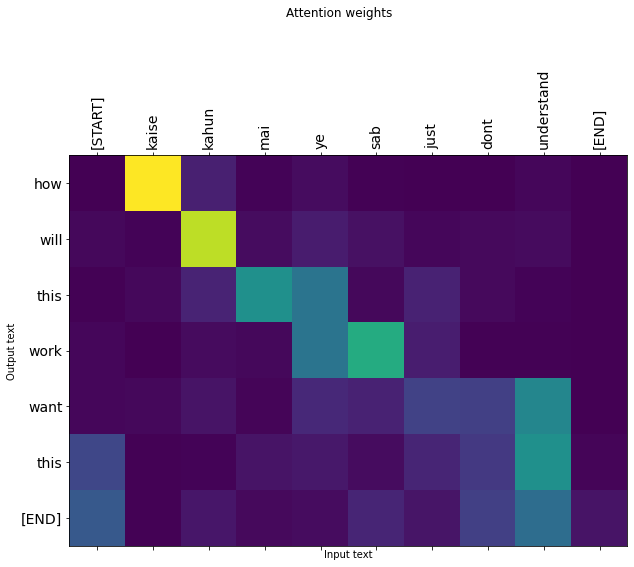

In [66]:
i = 0
plot_attention(result['attention'][i], three_input_text[i], result['text'][i])

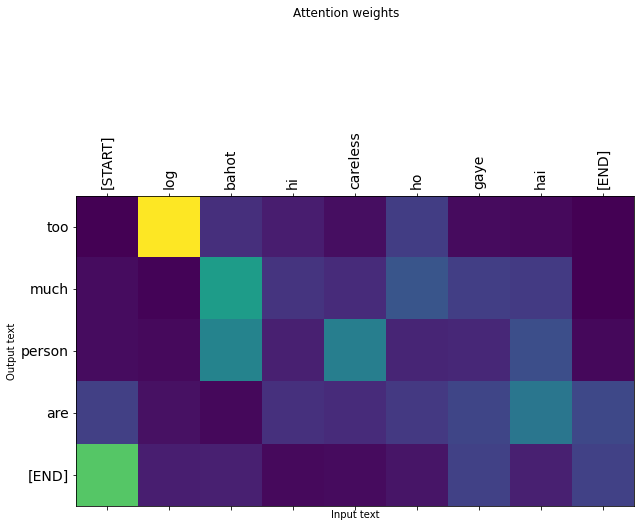

In [67]:
i = 1
plot_attention(result['attention'][i], three_input_text[i], result['text'][i])

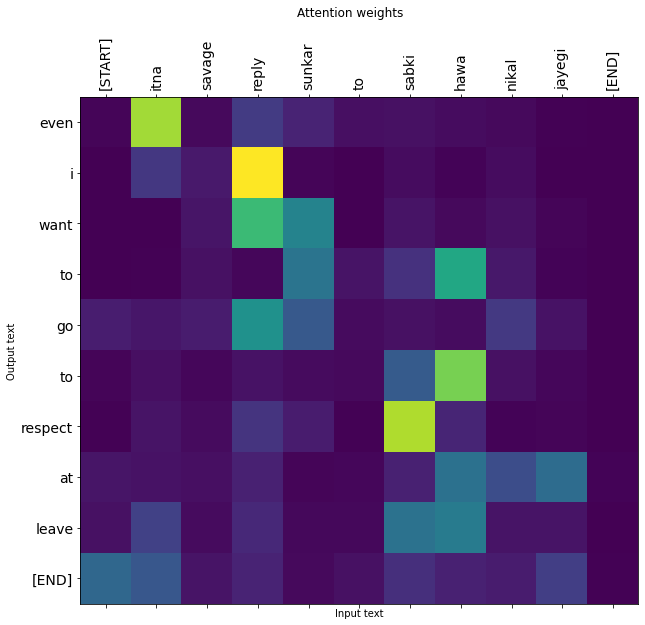

In [68]:
i = 2
plot_attention(result['attention'][i], three_input_text[i], result['text'][i])

In [69]:
tf.saved_model.save(translator, 'Hinglish_translation_attention',
                    signatures={'serving_default': translator.tf_translate})

In [ ]:
#import shutil

In [ ]:
#shutil.unpack_archive('/content/Hinglish_translation_attention.zip','Hinglish_translation_attention' )

In [70]:
phinc_test_preprocessed_data

,Sentence,English_Translation
6040,ndtv officeofrg narendramodi did he kept his o...,ndtv officeofrg narendramodi did he kept his o...
11804,rt umesalmaa team india to bjp itna bura toh h...,rt umesalmaa team india to bjp even we did not...
7997,integrated_me ulti to wo karegi kuch mahine baad,integrated_me she will vomit after some months
5620,kamaalrkhan sir aap kyu dar rahe ho aap to ink...,kamaalrkhan sir why are you scared you are dar...
4638,aur admin kaha busy ho yaar aj kal apk post k ...,and admin where are you busy man these days yo...
...,...,...
12348,rt iamsrk kya baat hai haryana ka sher aa gaya...,rt iamsrk great lion of haryana have come sult...
10963,mera beta kuch khata hi nahi sukh kar kaanta h...,my son doesn t eat anything at all he has drie...
5568,someuser aww my celebrity day is this thursday...,someuser aww this thursday is also my celebrit...
8849,theuglydude suzali ruz kaam karta tu sunday ku...,theuglydude suzali if you would have everyday ...


In [71]:
reloaded = tf.saved_model.load('/content/Hinglish_translation_attention')

In [72]:
# Evaluation on test Data 
reloaded = tf.saved_model.load('/content/Hinglish_translation_attention')
# result = reloaded.tf_translate(three_input_text)
result=reloaded.tf_translate(phinc_test_preprocessed_data['Sentence'])
predicted_result=[x.numpy().decode() for x in result['text']]
evaluated_file=pd.DataFrame()
evaluated_file['Hinglish Sentence']=phinc_test_preprocessed_data['Sentence']
evaluated_file['Actual_English_Translation']=phinc_test_preprocessed_data['English_Translation']
evaluated_file['Predicted_English_Translation']=predicted_result

In [73]:
evaluated_file=evaluated_file[evaluated_file['Actual_English_Translation'].map(len) >1]
evaluated_file.reset_index(drop=True,inplace=True)

In [74]:
evaluated_file

,Hinglish Sentence,Actual_English_Translation,Predicted_English_Translation
0,ndtv officeofrg narendramodi did he kept his o...,ndtv officeofrg narendramodi did he kept his o...,ndtv ruchikokcha sir mr modi your grace is cra...
1,rt umesalmaa team india to bjp itna bura toh h...,rt umesalmaa team india to bjp even we did not...,rat ushakokhar for india there s a pm ban we a...
2,integrated_me ulti to wo karegi kuch mahine baad,integrated_me she will vomit after some months,integratedme today too barkha nahi nick j had ...
3,kamaalrkhan sir aap kyu dar rahe ho aap to ink...,kamaalrkhan sir why are you scared you are dar...,kamaalrkhan sir why are you going to pray for ...
4,aur admin kaha busy ho yaar aj kal apk post k ...,and admin where are you busy man these days yo...,brother where did you be busy today comes to k...
...,...,...,...
4044,rt iamsrk kya baat hai haryana ka sher aa gaya...,rt iamsrk great lion of haryana have come sult...,rt suryatejborra what is the turtle belongs to...
4045,mera beta kuch khata hi nahi sukh kar kaanta h...,my son doesn t eat anything at all he has drie...,this will not burst by the rain we are less aw...
4046,someuser aww my celebrity day is this thursday...,someuser aww this thursday is also my celebrit...,someuser look in my thursday under this end wo...
4047,theuglydude suzali ruz kaam karta tu sunday ku...,theuglydude suzali if you would have everyday ...,yeah boys would have given a good time at it t...


In [75]:
def bleu_score(text1,text2):
    return bleu.sentence_bleu([text1.lower().split()],text2.lower().split())
scorer = rouge_scorer.RougeScorer(['rouge1', 'rougeL'], use_stemmer=True)

In [76]:
evaluated_file['bleu'] = evaluated_file.apply(lambda x: bleu_score(x.Actual_English_Translation,x.Predicted_English_Translation), axis=1)
evaluated_file['rogue'] = evaluated_file.apply(lambda x: scorer.score(x.Actual_English_Translation,x.Predicted_English_Translation)['rougeL'].fmeasure, axis=1)

evaluated_file['sentence_bleu'] = evaluated_file.apply(lambda x: sentence_bleu(x.Predicted_English_Translation,x.Actual_English_Translation.split()).score, axis=1)
evaluated_file['sentence_WER'] = evaluated_file.apply(lambda x: wer(x.Actual_English_Translation,x.Predicted_English_Translation), axis=1)
evaluated_file['sentence_meteor'] = evaluated_file.apply(lambda x: meteor_score([x.Actual_English_Translation.split()],x.Predicted_English_Translation.split()), axis=1)
evaluated_file[['bleu','rogue']].describe()
evaluated_file.head()


/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg

,Hinglish Sentence,Actual_English_Translation,Predicted_English_Translation,bleu,rogue,sentence_bleu,sentence_WER,sentence_meteor
0,ndtv officeofrg narendramodi did he kept his o...,ndtv officeofrg narendramodi did he kept his o...,ndtv ruchikokcha sir mr modi your grace is cra...,7.445183e-232,0.105263,2.908318,0.954545,0.046729
1,rt umesalmaa team india to bjp itna bura toh h...,rt umesalmaa team india to bjp even we did not...,rat ushakokhar for india there s a pm ban we a...,1.198833e-231,0.129032,3.218583,1.000000,0.099338
2,integrated_me ulti to wo karegi kuch mahine baad,integrated_me she will vomit after some months,integratedme today too barkha nahi nick j had ...,0.000000e+00,0.000000,0.000000,1.428571,0.000000
3,kamaalrkhan sir aap kyu dar rahe ho aap to ink...,kamaalrkhan sir why are you scared you are dar...,kamaalrkhan sir why are you going to pray for ...,3.216094e-01,0.454545,6.274655,0.583333,0.377966
4,aur admin kaha busy ho yaar aj kal apk post k ...,and admin where are you busy man these days yo...,brother where did you be busy today comes to k...,1.288230e-231,0.266667,3.458592,1.000000,0.140845


In [78]:
from google.colab import files
evaluated_file.to_csv('phinc_test_evaluated.csv', encoding = 'utf-8-sig')
files.download('phinc_test_evaluated.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>